In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd

Welcome to JupyROOT 6.24/06


In [2]:
from matplotlib import pyplot as plt
# set custom functions
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

In [3]:
def compute_amssig(s_, b_):
    if b_==0.0: return 0.0
    return np.sqrt(2*((s_+b_)*np.log(1+s_/b_)-s_))

def compute_sig(s_, b_):
    if b_==0.0: return 0.0
    return np.sqrt(s_/b_)

def generate_mesh(d=2, nbins=40):
    minbin = int(nbins/2)
    grid = [ [a] for a in np.linspace(minbin, nbins-1, nbins-minbin) ]
    for i in range(d-1):
        tmpgrid = []
        for pt in grid:
            for e in np.linspace(0, nbins-1, nbins):
                if e>=pt[-1]:
                    continue
                else:
                    tmppt = [ p_ for p_ in pt ]
                    tmppt.append(e)
                    tmpgrid.append(tmppt)
        grid = tmpgrid
    return grid

def get_stepped_plot(xarray, yarray):
    
    xsize = len(xarray)
    ysize = len(yarray)
    
    X = (xarray.reshape(xsize, 1)*np.ones(2)).flatten()[1:]
    Y = (yarray.reshape(ysize, 1)*np.ones(2)).flatten()[0:-1]
    
    return X, Y

def get_optimal_significance_cuts(hist_array, ncuts=2):
    significances = []
    optimal_cuts = []
    nbins = len(hist_array[1])-1
    meshgrid = generate_mesh(ncuts, nbins)
    for pt in meshgrid:
        tmp = []
        for icut, cut in enumerate(pt):
            if icut==0:
                int_sig = np.sum(hist_array[0][0][int(cut):])
                int_bkg = np.sum(hist_array[0][1][int(cut):])
            else:
                int_sig = np.sum(hist_array[0][0][int(cut):int(pt[icut-1])])
                int_bkg = np.sum(hist_array[0][1][int(cut):int(pt[icut-1])])
            tmp.append(compute_sig(int_sig, int_bkg))
        
        # get quadrature sum of significances
        sig = 0
        for s in tmp:
            sig += s**2
        significances.append(np.sqrt(sig))
    
    optidx = significances.index(max(significances))
    for c in meshgrid[optidx]:
        optimal_cuts.append(hist_array[1][int(c)])
    return significances[optidx], significances, meshgrid, optimal_cuts

In [4]:
scale_factors = {
    '2017':{
        'SignalNormSF': 0.72,
        'SignalSF': {
            'DS': 5.44E-4,
            'BD': 4.91E-4,
            'BU': 5.24E-4
        }
    },
    '2018':{
        'SignalNormSF': 0.86,
        'SignalSF': {
            'DS': 5.72E-04,
            'BD': 5.65E-04,
            'BU': 5.65E-04
        }
    }
}

In [5]:
fileName = "t3mminitree_xgb_maxdepth3_2018UL.csv";
df = pd.read_csv(fileName)

<Figure size 432x288 with 0 Axes>

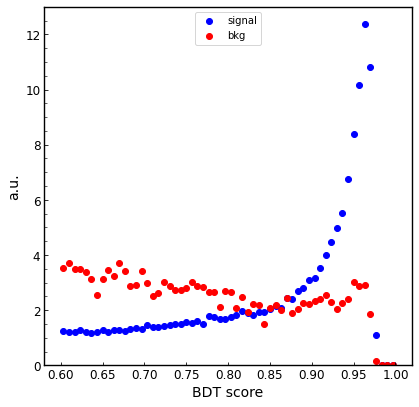

In [8]:
# category A
NBINS = 60
signal_mask = (df['dataMCType']!=0) & (df['category']==0)
bkg_mask = (df['dataMCType']==0) & (df['category']==0)

bdt_signal_categoryA = df[signal_mask]['bdt']
bdt_bkg_categoryA = df[bkg_mask]['bdt']
weight_signal_categoryA = df[signal_mask]['eventWeight']
weight_bkg_categoryA = df[bkg_mask]['eventWeight']

plt.clf()
plt.figure(figsize=(6.6,6.6))
hist_ = plt.hist([bdt_signal_categoryA, bdt_bkg_categoryA],
                 range=(0.6, 1), bins=NBINS,
#                 weights = [weight_signal_categoryA, weight_bkg_categoryA],
                 color=None, linewidth=0, histtype='step', density=True)
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][0], color='b', label='signal')
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][1], color='r', label='bkg')
plt.xlabel('BDT score', fontsize=14)
plt.ylabel('a.u.', fontsize=14)
plt.legend(loc='upper center')
plt.show()

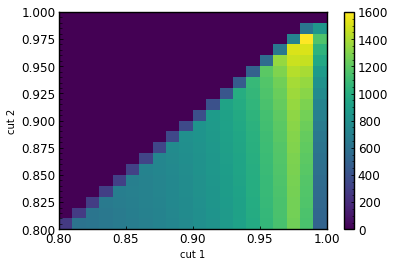

In [69]:
# plot significance as a function of cut-point
S, _heatmap, _grid, _cuts = get_optimal_significance_cuts(hist_)
hbinwidth=0.5*(hist_[1][1]-hist_[1][0])
xarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,0]]
yarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,1]]
plt.hist2d(xarray, yarray, weights=_heatmap, bins=(20, 20), range=((0.8, 1), (0.8, 1)))
plt.colorbar()
plt.xlabel('cut 1')
plt.ylabel('cut 2')
plt.show()

In [70]:
_cuts

[0.983, 0.979]

<Figure size 432x288 with 0 Axes>

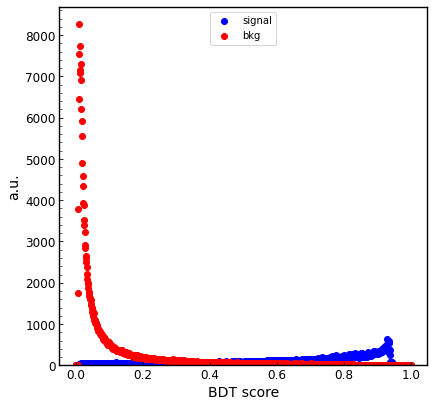

In [74]:
# category C
signal_mask = (df['dataMCType']!=0) & (df['category']==2)
bkg_mask = (df['dataMCType']==0) & (df['category']==2)

bdt_signal_categoryC = df[signal_mask]['bdt']
bdt_bkg_categoryC = df[bkg_mask]['bdt']
weight_signal_categoryC = df[signal_mask]['eventWeight']
weight_bkg_categoryC = df[bkg_mask]['eventWeight']

plt.clf()
plt.figure(figsize=(6.6,6.6))
hist_ = plt.hist([bdt_signal_categoryC, bdt_bkg_categoryC],
                 range=(0, 1), bins=NBINS,
#                 weights = [weight_signal_categoryC, weight_bkg_categoryC],
                 color=None, linewidth=0, histtype='step', density=False)
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][0], color='b', label='signal')
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][1], color='r', label='bkg')
plt.xlabel('BDT score', fontsize=14)
plt.ylabel('a.u.', fontsize=14)
plt.legend(loc='upper center')
plt.show()

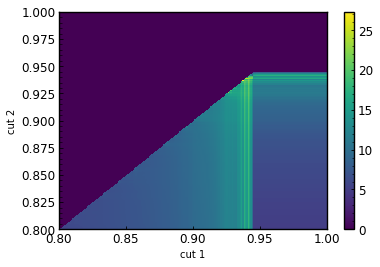

In [75]:
# plot significance as a function of cut-point
S, _heatmap, _grid, _cuts = get_optimal_significance_cuts(hist_)
hbinwidth=0.5*(hist_[1][1]-hist_[1][0])
xarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,0]]
yarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,1]]
plt.hist2d(xarray, yarray, weights=_heatmap, bins=(200, 200), range=((0.8, 1), (0.8, 1)))
plt.colorbar()
plt.xlabel('cut 1')
plt.ylabel('cut 2')
plt.show()

In [76]:
_cuts

[0.937, 0.936]

<Figure size 432x288 with 0 Axes>

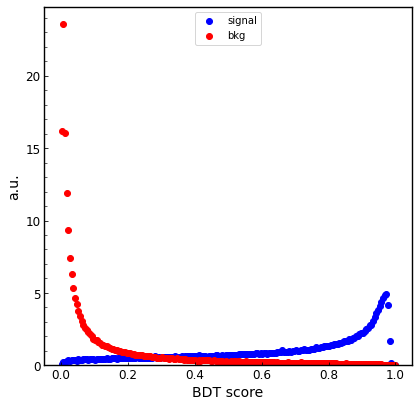

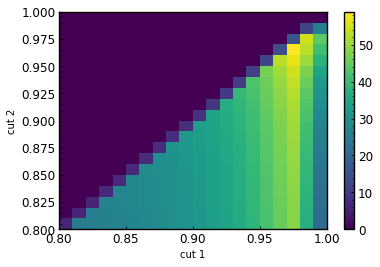

In [47]:
# category B
signal_mask = (df['dataMCType']!=0) & (df['category']==2)
bkg_mask = (df['dataMCType']==0) & (df['category']==2)

bdt_signal_categoryB = df[signal_mask]['bdt']
bdt_bkg_categoryB = df[bkg_mask]['bdt']
weight_signal_categoryB = df[signal_mask]['eventWeight']
weight_bkg_categoryB = df[bkg_mask]['eventWeight']

plt.clf()
plt.figure(figsize=(6.6,6.6))
hist_ = plt.hist([bdt_signal_categoryB, bdt_bkg_categoryB],
                 range=(0, 1), bins=200,
#                 weights = [weight_signal_categoryB, weight_bkg_categoryB],
                 color=None, linewidth=0, histtype='step', density=True)
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][0], color='b', label='signal')
plt.scatter(0.5*(hist_[1][:-1]+hist_[1][1:]), hist_[0][1], color='r', label='bkg')
plt.xlabel('BDT score', fontsize=14)
plt.ylabel('a.u.', fontsize=14)
plt.legend(loc='upper center')
plt.show()

# plot significance as a function of cut-point
S, _heatmap, _grid, _cuts = get_optimal_significance_cuts(hist_)
hbinwidth=0.5*(hist_[1][1]-hist_[1][0])
xarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,0]]
yarray = [hist_[1][int(idx)]+hbinwidth for idx in np.array(_grid)[:,1]]
plt.hist2d(xarray, yarray, weights=_heatmap, bins=(20, 20), range=((0.8, 1), (0.8, 1)))
plt.colorbar()
plt.xlabel('cut 1')
plt.ylabel('cut 2')
plt.show()

In [48]:
_cuts

[0.98, 0.975]